In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [2]:
random.seed(8)

In [3]:
# Import feature set for set8 ml model
s8_fset = pd.read_csv('./feature_data.csv')
msight_scores = pd.read_csv('./big_datasets/MS-full-proteome.csv')
ms_test = pd.read_csv('./datasets/MS-test-set.csv')
pplus = pd.read_csv('./datasets/methylated_sites_info.csv')

In [4]:
# Format s8 feature set 
# Format ID (uniprotID_K#) for feature set 
s8_fset['ID'] = s8_fset['ID'].str[:-3]

# Format ID (uniprotID_K#) for methylsight holdout set
ms_test['ID'] = ms_test['uniprot_id'] + '_K' + ms_test['position'].astype(str)

In [5]:
# Merge to generate holdout test set
holdout_set = pd.merge(ms_test, s8_fset, on = 'ID')

In [6]:
# CREATE TRAINING AND TEST SETS FOR S8 ML MODEL
from sklearn.model_selection import train_test_split
# create x and y sets for set8 ml test data
holdout_set = holdout_set.set_index('ID')
s8_test_y = holdout_set['METHYLATED']
s8_test_x = holdout_set.drop(['uniprot_id', 'position', 'METHYLATED'], axis=1)
# create x and y sets for set8 ml training data with test set removed
drop_rows = holdout_set.index
s8_fset = s8_fset.set_index('ID')
s8_fset.drop(drop_rows, inplace=True)
s8_train_y = s8_fset['METHYLATED']
s8_train_x = s8_fset.drop(['METHYLATED'], axis=1)
# split training sets in two for 1) training of set8 model then 2) training of combo model
s8_mod_train_x, s8_combo_train_x, s8_mod_train_y, s8_combo_train_y = train_test_split(
    s8_train_x, s8_train_y, test_size=0.5, random_state=8, stratify=s8_train_y)

In [7]:
# count training and test set sizes for 1) and 2)
from collections import Counter
print('Hold-Out Set:', Counter(s8_test_y))
print('Without Hold-Out Set:', Counter(s8_train_y))
print('S8 Model Training:', Counter(s8_mod_train_y))
print('Combo Model Training:', Counter(s8_combo_train_y))

Hold-Out Set: Counter({0.0: 159, 1.0: 12})
Without Hold-Out Set: Counter({0.0: 4221, 1.0: 201})
S8 Model Training: Counter({0.0: 2111, 1.0: 100})
Combo Model Training: Counter({0.0: 2110, 1.0: 101})


In [8]:
# TEST S8 MODEL on S8 Model Training data
# Linear Discriminant Analysis produced the best results in testing - use it here
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline
from numpy import mean
from sklearn.metrics import recall_score
from sklearn.metrics import make_scorer

discrim = LinearDiscriminantAnalysis(tol = 0.007070707070707071, store_covariance=False, solver='svd')
over = RandomOverSampler(sampling_strategy=0.35)
steps = [('sampling', over), ('model', discrim)]
pipeline = Pipeline(steps=steps)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3)
scores = cross_val_score(pipeline, s8_mod_train_x, s8_mod_train_y, cv=cv, scoring="f1")
print("score:", mean(scores))

score: 0.11228679996517554


In [9]:
# Test fit of base SET8 ML model - low amount of positives so set test set size to 30%
s8_tr_x, s8_te_x, s8_tr_y, s8_te_y = train_test_split(s8_mod_train_x, s8_mod_train_y, stratify=s8_mod_train_y, test_size=0.3)

In [10]:
# GENERATE METRICS
def model_metric_generation(X_train, y_train, X_test, y_test, final_model, sampler):
    
    threshold = 0.0
    rec, prec, spec, sens, thresh, fpr, tpr = [], [], [], [], [], [], []
    print('Training data:', Counter(y_train))
    
    if sampler != None:
        # Apply sampling method to training data
        X_train, y_train = sampler.fit_resample(X_train, y_train)
        print('Training data after sampling:', Counter(y_train))
    
    print('Testing/validation data:', Counter(y_test))
    
    if final_model == 'simp_avg':
        y_proba = (X_test['PRIMARY_ML_SCORE'] + X_test['SECONDARY_ML_SCORE'])/2
        print('Simple average selected...')
    else:
        # Fit the model to our training data
        final_model = clone(final_model)
        final_model = final_model.fit(X_train, y_train)

        # Calculate the probability on testing data
        y_proba = final_model.predict_proba(X_test)
        y_proba = y_proba[:, [1]]   #select the probability for the positive case only
    
    # Now generate metrics for each threshold from 0.0 - 1.0
    while threshold <= 1.01:
        # Select only the scores over our threshold
        cond = y_proba >= threshold
        
        # Convert to 1 or 0 values
        y_pred = np.where((y_proba>=threshold), 1, y_proba)
        y_pred = np.where((y_proba<threshold), 0, y_pred)
        
        # Calculate recall
        recall = recall_score(y_test, y_pred)
        rec.append(recall)
        
        # Calculate precision
        precision = precision_score(y_test, y_pred)
        prec.append(precision)
        
        #Calculate specificity + sensitivity
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        specificity = tn/(tn+fp)
        spec.append(specificity)
        sensitivity = tp/(tp+fn)
        sens.append(sensitivity)
        
        # Calculate fpr + tpr
        false_pos_rate = fp/(fp+tn)
        fpr.append(false_pos_rate)
        true_pos_rate = tp/(tp+fn)
        tpr.append(true_pos_rate)
        
        # Update threshold
        thresh.append(threshold)
        threshold += 0.01
        
    # Determine ROC auc
    auc_m = roc_auc_score(y_test, y_proba)
    
    # Make metric dataframe
    pr_m = pd.DataFrame(list(zip(thresh, rec, spec, prec, sens)), columns=['Threshold'
                                                                              , 'Recall'
                                                                              , 'Specificity'
                                                                              , 'Precision'
                                                                              , 'Sensitivity'])

    # Make ROC dataframe
    roc_m = pd.DataFrame(list(zip(fpr, tpr)), columns = ['fpr', 'tpr'])
    
    return pr_m, roc_m, auc_m
    

In [11]:
from sklearn.base import clone
from sklearn.metrics import precision_score, confusion_matrix, roc_auc_score, auc

pr_m, roc_m, auc_m = model_metric_generation(s8_tr_x, s8_tr_y, s8_te_x, s8_te_y, clone(discrim), over)

Training data: Counter({0.0: 1477, 1.0: 70})
Training data after sampling: Counter({0.0: 1477, 1.0: 516})
Testing/validation data: Counter({0.0: 634, 1.0: 30})


/Users/nashiragrigg/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [12]:
auc_m = auc(roc_m['fpr'],roc_m['tpr'])

In [13]:
import matplotlib.pyplot as plt
import os

# PLOTTING
def Plot (pr_metrics, pr_saveas, roc_metrics, roc_auc, roc_saveas, metric_saveas):
    plt.clf()
    plt.plot([0,1], [0, 1], linestyle='--', label='No Skill')
    plt.plot(roc_metrics['fpr'],roc_metrics['tpr'],label="Model, ROC AUC="+str(round(roc_auc, 3)))
    plt.legend(title='', loc='lower right', ncol=1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    roc_save_pdf = os.path.abspath(roc_saveas+'.pdf')
    roc_save_png = os.path.abspath(roc_saveas+'.png')
    #plt.savefig(roc_save_png, dpi=72, bbox_inches='tight')
    plt.savefig(roc_save_pdf, dpi=300, bbox_inches='tight')
    plt.clf()
    plt.plot([0,1],[0,0], linestyle='--', label='No Skill')
    pr_auc_score = auc(pr_metrics['Recall'],pr_metrics['Precision'])
    plt.plot(pr_metrics['Recall'],pr_metrics['Precision'], label='Model (PR AUC = '+str(round(pr_auc_score, 3))+')')
    plt.legend(title='', loc='upper right', ncol=1)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.ylim(-0.05,1.05)
    pr_save_pdf = os.path.abspath(pr_saveas+'.pdf')
    pr_save_png = os.path.abspath(pr_saveas+'.png')
    #plt.savefig(pr_save_png, dpi=72, bbox_inches='tight')
    plt.savefig(pr_save_pdf, dpi=300, bbox_inches='tight')
    plt.clf()
    pr_metrics = pr_metrics.drop(columns='Sensitivity')
    # Plot scores from metrics method as pr and roc curves
    sns.set_context('paper')
    ax = sns.lineplot(x='Threshold', y='value', hue='variable', data=pd.melt(pr_metrics, 'Threshold'), ci=None)
    ax.set(ylabel='Performance')
    ax.grid()
    ax.legend(title='', bbox_to_anchor=(.5, 1), loc='lower center', ncol=3)
    plt.ylim(0,1)
    plt.xlim(0,1)
    metric_save_pdf = os.path.abspath(metric_saveas+'.pdf')
    metric_save_png = os.path.abspath(metric_saveas+'.png')
    #plt.savefig(metric_save_png, dpi=72, bbox_inches='tight')
    plt.savefig(metric_save_pdf, dpi=300, bbox_inches='tight')

/var/folders/p8/7dg76m153tbg1p6ln0gknfvw0000gn/T/ipykernel_73037/1445742637.py:32: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(x='Threshold', y='value', hue='variable', data=pd.melt(pr_metrics, 'Threshold'), ci=None)


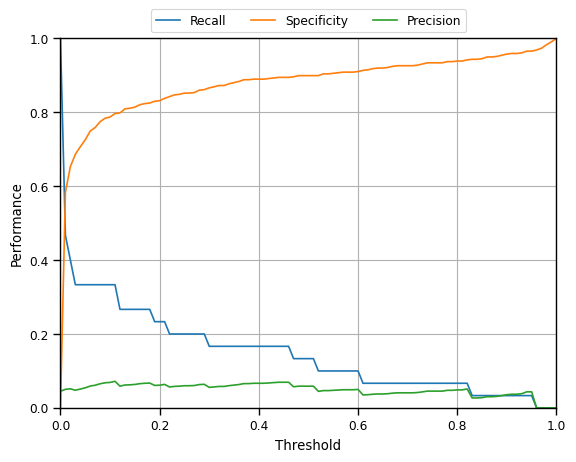

In [14]:
Plot (pr_m, 'Precision_Recall_Curve_S8ML_Base', roc_m, auc_m, 'ROC_S8ML_Base', 'Metric_Curve_S8ML_Base')

In [15]:
# TRAIN S8 MODEL FOR ENSEMBLE MODEL FITTING
# fit model to training data
step2 = [('sampling', over)]
pip2 = Pipeline(steps=step2)
s8_X, s8_y = pip2.fit_resample(s8_mod_train_x, s8_mod_train_y)
model = discrim.fit(s8_X, s8_y)

<Figure size 640x480 with 0 Axes>

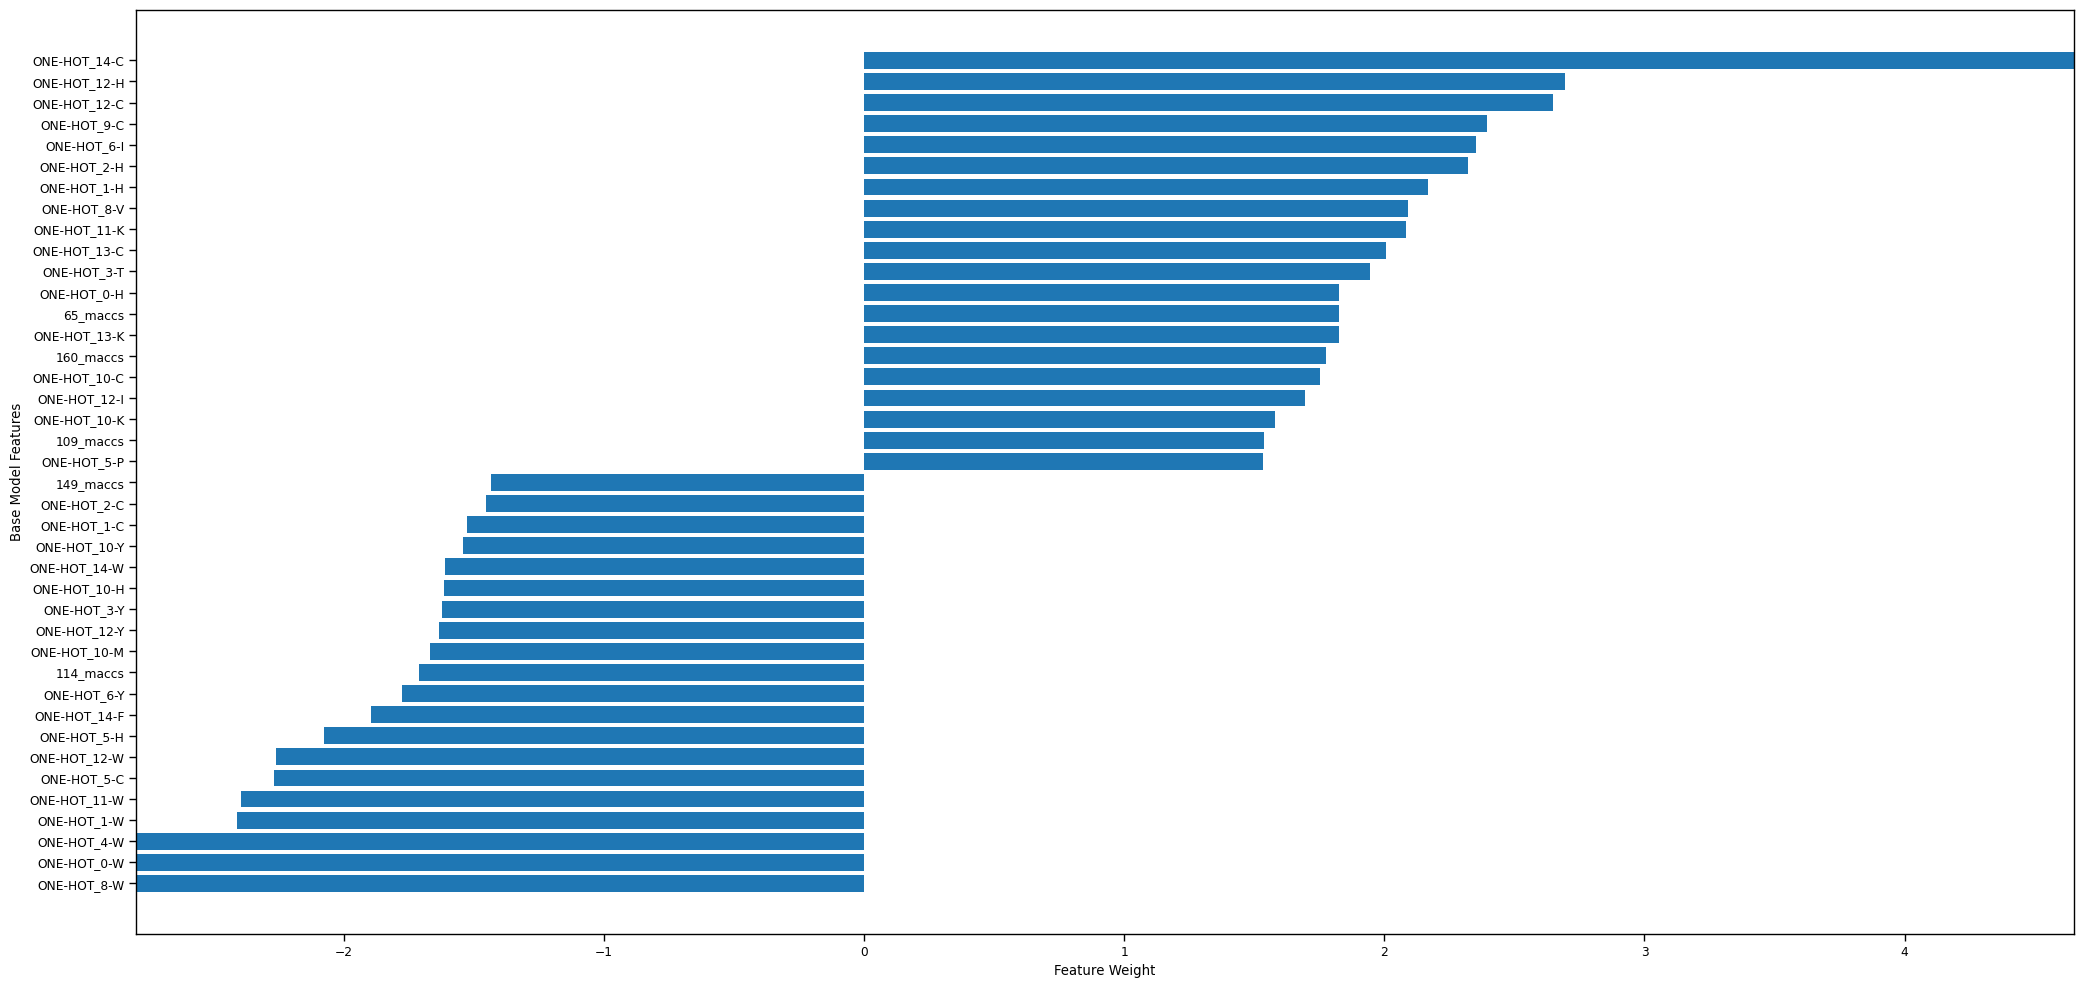

In [16]:
# GENERATE FEATURE IMPORTANCE GRAPH FOR BASE MODEL
importance = model.coef_
# Arrange feature importance in a df with labels
imp_name = pd.DataFrame(zip(s8_mod_train_x.columns, importance[0]), columns=['Feature', 'Importance'])

# Isolate the top/bottom n (defined by c)
c = 20
sorted_imp = imp_name.sort_values(by='Importance')
bot = sorted_imp[:c]
top = sorted_imp[-c:]
imp_iso_c = pd.concat([bot, top])

# Graph it 
plt.clf()
plt.figure(figsize=(25, 12))
plt.barh(imp_iso_c['Feature'], imp_iso_c['Importance'])
#plt.xticks(rotation='vertical')
plt.xlabel('Feature Weight')
plt.ylabel('Base Model Features')
plt.xlim(-2.8, 4.65)
plt.savefig('./SET8_Base_Model_Feature_Importance.pdf', dpi=300, bbox_inches='tight')

In [17]:
# PREDICT SCORES FOR COMBO TRAINING SET USING S8 MODEL FOR INSERTION INTO COMBO MODEL
s8_scores = model.predict_proba(s8_combo_train_x)
combo_train_x = pd.DataFrame(s8_scores)
combo_train_x = combo_train_x.rename(columns={1:'s8_proba_methylated'})
combo_train_x = combo_train_x.drop([0], axis=1)
combo_train_x = combo_train_x.set_index(s8_combo_train_x.index)
combo_train_x['methylated'] = s8_combo_train_y

In [18]:
# ADD MS SCORES TO COMBO TRAINING SET
# formatting
ms_combo_train_x = pd.DataFrame(msight_scores['Score'])
msight_scores['ID'] = msight_scores['UniProtID'] + '_K' + msight_scores['Site'].astype(str)
ms_combo_train_x = ms_combo_train_x.set_index(msight_scores['ID'])
ms_combo_train_x = ms_combo_train_x.rename(columns={'Score':'ms_proba_methylated'})

# add to s8 data
X_combo_train = pd.merge(combo_train_x, ms_combo_train_x, left_index=True, right_index=True, how='inner')

# isolate methylated data for y combo train
y_combo_train = X_combo_train['methylated']
X_combo_train = X_combo_train.drop(['methylated'], axis=1)

In [19]:
print('MethylSight and SET8ML Predicted Positives:', len(X_combo_train[(X_combo_train['ms_proba_methylated'] >= 0.5) & (X_combo_train['s8_proba_methylated'] >= 0.5)]))

MethylSight and SET8ML Predicted Positives: 107


In [20]:
print('SET8ML Predicted Positives:', len(X_combo_train[X_combo_train['s8_proba_methylated'] >= 0.5]))

SET8ML Predicted Positives: 261


In [21]:
# quick count of classes in combo train
print('Combination Model Training Set:', Counter(y_combo_train))

Combination Model Training Set: Counter({0.0: 2076, 1.0: 97})


In [22]:
# CREATE COMBO TEST SET
# y value is experimental methylation data
y_combo_test = holdout_set['METHYLATED']
# generate s8 scores for combo x data
X_s8_combo_test = holdout_set.drop(['ground_truth', 'uniprot_id', 'METHYLATED', 'position'], axis=1)
s8_t_scores = model.predict_proba(X_s8_combo_test)
x_combo_test = pd.DataFrame(s8_t_scores)
x_combo_test = x_combo_test.rename(columns={1:'s8_proba_methylated'})
x_combo_test = x_combo_test.drop([0], axis=1)
x_combo_test = x_combo_test.set_index(X_s8_combo_test.index)
x_combo_test['methylated'] = y_combo_test

In [23]:
# pull out ms scores from ms data for combo test x data
X_combo_test = pd.merge(x_combo_test, ms_combo_train_x, left_index=True, right_index=True, how='inner')

# isolate methylated data for y combo train
y_combo_test = X_combo_test['methylated']
X_combo_test = X_combo_test.drop(['methylated'], axis=1)

In [24]:
# FIT AND TEST MODELS : train with X_combo_train and y_combo_train,
# test with X_combo_test and y_combo_test

In [25]:
# VOTING ~ Mean Probabilities
mean_prob = (X_combo_test['s8_proba_methylated'] + X_combo_test['ms_proba_methylated'])/2

In [26]:
# VOTING ~ Sum Probabilities
sum_prob = (X_combo_test['s8_proba_methylated'] + X_combo_test['ms_proba_methylated'])

In [27]:
# GRAPH VOTING

from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix

def voting_metrics_gen(mean_prob):
    # METRIC v. THRESHOLD
    threshold = 0.0
    rec = []
    prec = []
    spec = []
    thresh = []

    while threshold <= 1.01:

        # select just the scores over our threshold
        cond = mean_prob >= threshold
        # convert to 1 or 0 values
        y_pred = np.where((mean_prob>=threshold), 1, mean_prob)
        y_pred = np.where((y_pred<threshold), 0, y_pred)
        # calculate recall
        recall = recall_score(y_combo_test, y_pred)
        rec.append(recall)
        # calculate precision
        precision = precision_score(y_combo_test, y_pred)
        prec.append(precision)
        # calculate specificity
        tn, fp, fn, tp = confusion_matrix(y_combo_test, y_pred).ravel()
        specificity = tn/(tn+fp)
        spec.append(specificity)

        # update threshold
        thresh.append(threshold)
        threshold += 0.01
        #print(threshold)

    voting_metrics = pd.DataFrame(list(zip(thresh, rec, spec, prec)), columns=['Threshold'
                                                                                  , 'Recall'
                                                                                  , 'Specificity'
                                                                                  , 'Precision'])
    return voting_metrics

In [28]:
# Graph ROC + PR Curves

In [29]:
mean_voting_metrics = voting_metrics_gen(mean_prob)
sum_voting_metrics = voting_metrics_gen(sum_prob)

/Users/nashiragrigg/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nashiragrigg/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nashiragrigg/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nashiragrigg/anaconda3/lib/python3.11/site-packages/sklearn/met

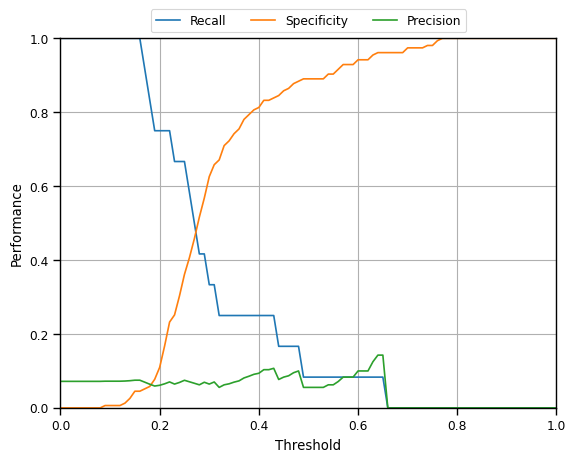

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context('paper')
ax = sns.lineplot(x='Threshold', y='value', hue='variable', data=pd.melt(mean_voting_metrics, 'Threshold'))
ax.set(ylabel='Performance')
ax.grid()
ax.legend(title='', bbox_to_anchor=(.5, 1), loc='lower center', ncol=3)
plt.ylim(0,1)
plt.xlim(0,1)
plt.savefig('./v1_mean_ms_s8.pdf', dpi=300, bbox_inches="tight")

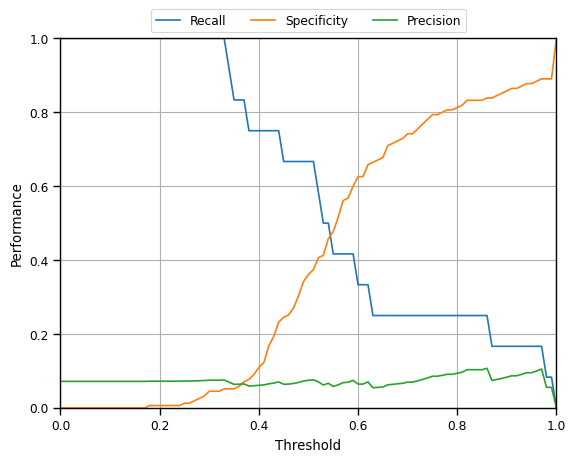

In [31]:
sns.set_context('paper')
ax = sns.lineplot(x='Threshold', y='value', hue='variable', data=pd.melt(sum_voting_metrics, 'Threshold'))
ax.set(ylabel='Performance')
ax.grid()
ax.legend(title='', bbox_to_anchor=(.5, 1), loc='lower center', ncol=3)
plt.ylim(0,1)
plt.xlim(0,1)
plt.savefig('./v1_sum_ms_s8.pdf', dpi=300, bbox_inches="tight")

In [32]:
# STACKED METHOD - DETERMINED TO BEST PERFORM WITH LOGISTIC REGRESSION

In [42]:
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression

# Logistic Regression + SVMSMOTE oversampling produced highest score - proceed with those
logit = LogisticRegression(max_iter=1000)
svm_smote = SVMSMOTE()
steps = [('sampling', svm_smote), ('clf', logit)]
pipe = Pipeline(steps=steps)
# fit the model to the training data
f_model = pipe.fit(X_combo_train, y_combo_train)

# GRAPHING: METRIC v. THRESHOLD
threshold = 0.0
t_rec = []
t_prec = []
t_spec = []
thresh = []

while threshold <= 1:
    # calculate probability on testing data
    y_proba = f_model[1].predict_proba(X_combo_test)
    y_proba = y_proba[:, [1]]   #select the probability for the positive case only
    
    # select just the scores over our threshold
    cond = y_proba >= threshold
    # convert to 1 or 0 values
    y_pred = np.where((y_proba>=threshold), 1, y_proba)
    y_pred = np.where((y_pred<threshold), 0, y_pred)
    # calculate recall
    recall = recall_score(y_combo_test, y_pred)
    t_rec.append(recall)
    # calculate precision
    precision = precision_score(y_combo_test, y_pred)
    t_prec.append(precision)
    # calculate specificity
    tn, fp, fn, tp = confusion_matrix(y_combo_test, y_pred).ravel()
    specificity = tn/(tn+fp)
    t_spec.append(specificity)

    # update threshold
    thresh.append(threshold)
    threshold += 0.01


metrics = pd.DataFrame(list(zip(thresh, t_rec, t_spec, t_prec)), columns=['Threshold'
                                                                              , 'Recall'
                                                                              , 'Specificity'
                                                                              , 'Precision'])

/Users/nashiragrigg/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nashiragrigg/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nashiragrigg/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nashiragrigg/anaconda3/lib/python3.11/site-packages/sklearn/met

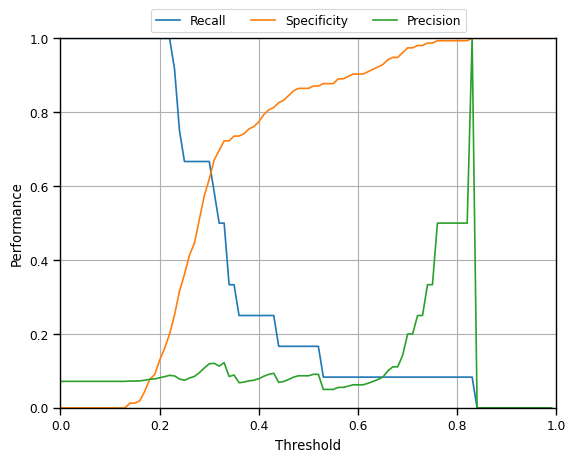

In [43]:
# graph it
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context('paper')
ax = sns.lineplot(x='Threshold', y='value', hue='variable', data=pd.melt(metrics, 'Threshold'))
ax.set(ylabel='Performance')
ax.grid()
ax.legend(title='', bbox_to_anchor=(.5, 1), loc='lower center', ncol=3)
plt.ylim(0,1)
plt.xlim(0,1)
plt.savefig('./v1_combined_ms_s8_logistic_regression_svmsmote.pdf', dpi=300, bbox_inches="tight")